### 1. Load data

In [124]:
import torch
import os
from torch.utils import data

In [125]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [126]:
# data_folder = 'data/'
data_folder = '/content/drive/MyDrive/CCAI 2024 Tutorials/1_LULC_ResNET50/data'

In [127]:
# !unzip '/content/drive/MyDrive/CCAI 2024 Tutorials/1_LULC_ResNET50/data/EuroSAT.zip' -d \
# '/content/drive/MyDrive/CCAI 2024 Tutorials/1_LULC_ResNET50/data/'

In [128]:
class EuroSAT(data.Dataset):
    def __init__(self,dataset,transform = None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self,index):
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        y = dataset[index][1]
        return x,y

    def __len__(self):
        return len(dataset)


In [129]:
train_loader = torch.load(os.path.join(data_folder,'train_loader.pth'))
val_loader = torch.load(os.path.join(data_folder,'val_loader.pth'))
test_loader = torch.load(os.path.join(data_folder,'test_loader.pth'))

<ipython-input-129-0b32d987e57a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_loader = torch.load(os.path.join(data_folder,'train_loader.pth'))
<ipython-input-129-

In [130]:
batch_size = 16 #from previous notebook

In [131]:
print(len(train_loader.dataset))
print(len(val_loader.dataset))
print(len(test_loader.dataset))

18900
4050
4050


In [132]:
(len(train_loader.dataset)) + (len(val_loader.dataset)) + (len(test_loader.dataset))

27000

The sizes match the original dataset size and the splits sizes

### 2. Load model

In [133]:
import torchvision
from torchvision import models

Remember to upgrade torch and torchvision in case the models method doesn't support the weights (I had a really old installation and had to upgrade)

In [134]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)


In [135]:
import torchsummary

In [136]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: Tesla T4


In [137]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [138]:
NUM_CLASSES = 10

In [139]:
model.fc = torch.nn.Linear(model.fc.in_features,NUM_CLASSES)

In [140]:
model = model.to(device)

In [141]:
torchsummary.summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### Specify model training parameters

In [142]:
n_epochs = 10
lr = 0.001


In [143]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=lr)

What torch.max() does

In [144]:
a = torch.randn(4,4)
a

tensor([[-0.6825, -0.1368,  0.2097,  0.7891],
        [-0.9447, -1.7051, -1.6065, -0.0363],
        [-0.1264,  0.3046, -0.1848, -1.3705],
        [-0.3926, -0.7701, -2.2221, -0.6238]])

In [145]:
torch.max(a,1)

torch.return_types.max(
values=tensor([ 0.7891, -0.0363,  0.3046, -0.3926]),
indices=tensor([3, 3, 1, 0]))

In [146]:
import tqdm

In [147]:
def train(model,dataloader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    running_total_correct = 0.0

    for i,(inputs,labels) in enumerate(tqdm.tqdm(dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(labels)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs,labels)

        loss.backward()

        optimizer.step()

        _,preds = torch.max(outputs,1)

        running_loss += loss.item() *inputs.size(0)
        running_total_correct += torch.sum(preds == labels)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = (running_total_correct /  len(dataloader.dataset)) * 100
    print(f'Train loss : {epoch_loss:.2f};Accuracy : {epoch_accuracy:.2f}')

    return epoch_loss, epoch_accuracy

### Model evaluation function

In [148]:
def evaluate(model,dataloader,criterion,phase='val'):
    model.eval()

    running_loss = 0.0
    running_total_correct = 0.0

    for i,(inputs,labels) in enumerate(tqdm.tqdm(dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            _, preds = torch.max(outputs,1)

        running_loss += loss.item() * inputs.size(0)
        running_total_correct += torch.sum(preds == labels)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
    print(f'{phase.title()} Loss = {epoch_loss:.2f}; Accuracy = {epoch_accuracy:.2f}')

    return epoch_loss,epoch_accuracy

### Model fit function

In [149]:
import numpy as np

In [150]:
def fit(model,train_loader,val_loader,n_epochs,lr,criterion,optimizer):
    best_loss = np.inf
    best_model = None

    for epoch in range(n_epochs):
        print(f'Epoch : {epoch+1}')
        train(model,train_loader,criterion,optimizer)
        val_loss,_ = evaluate(model,val_loader,criterion)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model

    return best_model

In [151]:
from torchvision import datasets

In [152]:
data_folder + 'EuroSAT'

'/content/drive/MyDrive/CCAI 2024 Tutorials/1_LULC_ResNET50/dataEuroSAT'

In [153]:
dataset = datasets.ImageFolder(os.path.join(data_folder, 'EuroSAT','2750'))

In [154]:
dataset.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [155]:
import matplotlib.pyplot as plt

In [156]:
class_names = dataset.classes

In [157]:
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

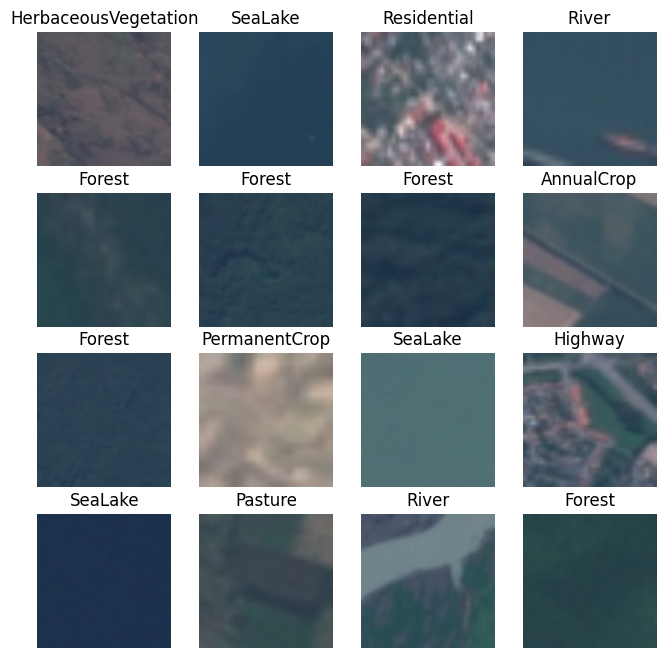

In [158]:
n = 4
inputs, classes = next(iter(train_loader))
fig, axes = plt.subplots(n, n, figsize=(8, 8))

for i in range(n):
  for j in range(n):
    image = inputs[i * n + j].numpy().transpose((1, 2, 0))
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

    title = class_names[classes[i * n + j]]
    axes[i, j].imshow(image)
    axes[i, j].set_title(title)
    axes[i, j].axis('off')

In [162]:
n_epochs

10

### Train the model
takes about 0.5 hour

In [163]:
best_model = fit(model,train_loader,val_loader,n_epochs,lr,criterion,optimizer)

Epoch : 1


100%|██████████| 1182/1182 [03:39<00:00,  5.39it/s]


Train loss : 0.73;Accuracy : 76.87


100%|██████████| 254/254 [00:34<00:00,  7.38it/s]


Val Loss = 0.49; Accuracy = 86.59
Epoch : 2


100%|██████████| 1182/1182 [03:36<00:00,  5.47it/s]


Train loss : 0.60;Accuracy : 80.68


100%|██████████| 254/254 [00:34<00:00,  7.28it/s]


Val Loss = 0.43; Accuracy = 87.80
Epoch : 3


100%|██████████| 1182/1182 [03:36<00:00,  5.47it/s]


Train loss : 0.53;Accuracy : 82.58


100%|██████████| 254/254 [00:33<00:00,  7.49it/s]


Val Loss = 0.31; Accuracy = 91.11
Epoch : 4


100%|██████████| 1182/1182 [03:38<00:00,  5.40it/s]


Train loss : 0.47;Accuracy : 84.61


100%|██████████| 254/254 [00:34<00:00,  7.43it/s]


Val Loss = 0.26; Accuracy = 92.52
Epoch : 5


100%|██████████| 1182/1182 [03:38<00:00,  5.40it/s]


Train loss : 0.43;Accuracy : 86.03


100%|██████████| 254/254 [00:36<00:00,  6.99it/s]


Val Loss = 0.23; Accuracy = 93.19
Epoch : 6


100%|██████████| 1182/1182 [03:39<00:00,  5.37it/s]


Train loss : 0.41;Accuracy : 86.66


100%|██████████| 254/254 [00:35<00:00,  7.11it/s]


Val Loss = 0.20; Accuracy = 94.81
Epoch : 7


100%|██████████| 1182/1182 [03:42<00:00,  5.32it/s]


Train loss : 0.38;Accuracy : 87.48


100%|██████████| 254/254 [00:36<00:00,  7.00it/s]


Val Loss = 0.19; Accuracy = 94.07
Epoch : 8


100%|██████████| 1182/1182 [03:41<00:00,  5.34it/s]


Train loss : 0.37;Accuracy : 88.15


100%|██████████| 254/254 [00:35<00:00,  7.15it/s]


Val Loss = 0.14; Accuracy = 95.58
Epoch : 9


100%|██████████| 1182/1182 [03:41<00:00,  5.34it/s]


Train loss : 0.35;Accuracy : 88.24


100%|██████████| 254/254 [00:35<00:00,  7.19it/s]


Val Loss = 0.15; Accuracy = 95.43
Epoch : 10


100%|██████████| 1182/1182 [03:43<00:00,  5.30it/s]


Train loss : 0.34;Accuracy : 89.21


100%|██████████| 254/254 [00:34<00:00,  7.35it/s]

Val Loss = 0.13; Accuracy = 96.15


In [164]:
test_loss, _ = evaluate(best_model, test_loader, criterion, phase="test")

100%|██████████| 254/254 [00:35<00:00,  7.09it/s]

Test Loss = 0.13; Accuracy = 95.83


### Save model

In [171]:
model_dir = data_folder.replace('data','model')
model_dir

'/content/drive/MyDrive/CCAI 2024 Tutorials/1_LULC_ResNET50/model'

In [170]:
os.makedirs(model_dir,exist_ok=True)

In [175]:
torch.save(best_model.state_dict(),os.path.join(model_dir,'best_model.pth'))

### Visualize the results

In [ ]:
def evaluate(model, dataloader, criterion, phase="val"):
  model.eval()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm.tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print(f"{phase.title()} Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")

  return epoch_loss, epoch_accuracy

tensor([3, 4, 8, 7, 9, 9, 0, 1, 3, 7, 0, 5, 2, 1, 6, 4])


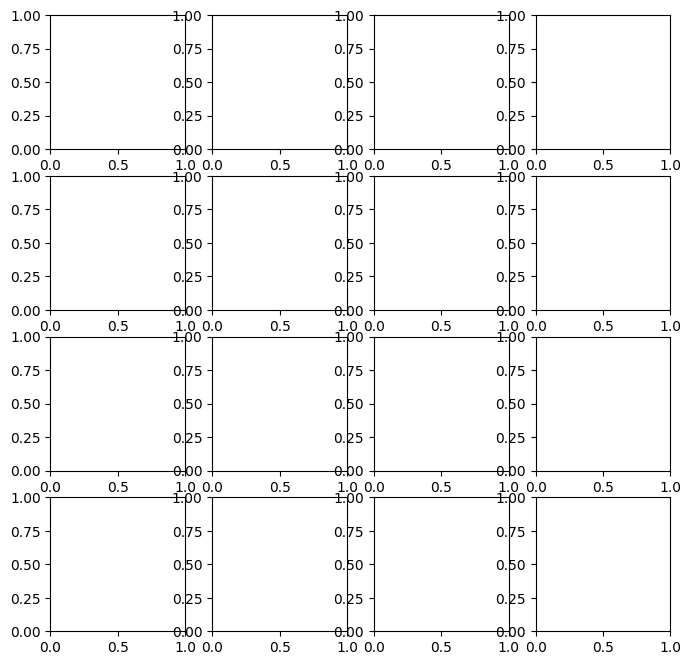

In [180]:
n = 4
inputs, classes = next(iter(test_loader))
fig, axes = plt.subplots(n, n, figsize=(8, 8))

inputs = inputs.to(device)
classes = classes.to(device)

for i in range(n):
  for j in range(n):
    image = inputs[i * n + j].numpy().transpose((1, 2, 0))
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)



for i, (inputs, labels) in enumerate(tqdm.tqdm(test_loader)):
  inputs = inputs.to(device)
  labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)

for i in range(n):
  for j in range(n):
    image = inputs[i * n + j].numpy().transpose((1, 2, 0))
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

    output = model(image.unsqueeze(0))
    _, pred = torch.max(output, 1)
    title = class_names[classes[i * n + j]]
    axes[i, j].imshow(image)
    axes[i, j].set_title(title)
    axes[i, j].axis('off')

In [ ]:
image, label = test_data[index]

# Predict on sample
model = model.to("cpu")
output = model(image.unsqueeze(0))
_, pred = torch.max(output, 1)